# 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기

목표
- 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
- 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
- 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

In [1]:
import os

import konlpy
import gensim
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(sns.__version__)

0.6.0
3.8.3
1.2.2
0.12.2


In [2]:
from tqdm import tqdm
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import dot
from numpy.linalg import norm


## 임베딩 모델 준비

1. 파일에서 데이터를 읽어온다.
2. 품사 태깅을 한다.
3. 명사만 고른다.
4. Word2Vec을 학습한다.
5. 테스트

In [3]:
# Konlpy의 Okt 패키지를 사용합니다. 
okt = Okt()

# 명사를 저장할 빈 리스트 생성
tokenized = []

# 파일을 읽기 모드 열기
with open('synopsis/synopsis.txt', 'r') as file:
    
    # 파일 내의 각 라인을 읽어 처리하기 위한 무한 루프
    while True:
        # 파일에서 한 줄을 읽는다.
        line = file.readline()
        
        # EOF 감지
        if not line:
            break
        
        # okt.pos 함수를 이용해 해당 라인의 텍스트를 형태소 분석하고, 품사 정보를 얻는다.
        # 여기서 stem=True는 어근을 추출하는 것이며, norm=True는 표준화를 의미한다.
        words = okt.pos(line, stem=True, norm=True)
        
        # 형태소 분석 결과를 저장할 빈 리스트를 생성한다.
        res = []
        
        # 형태소 분석 결과에서 명사('Noun')인 품사만을 선택하여 res 리스트에 추가한다.
        # 'Adjective', 'Verb' 등 다른 품사를 추가하려면 ["Noun", "Adjective", "Verb"] 등으로 조건을 넣을 수 있다.
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        
        # 명사만 추출한 결과를 tokenized 리스트에 추가합니다.
        tokenized.append(res)


In [4]:
# gensim 패키지의 Word2Vec 모델을 사용하여 토큰화된 단어(tokenized)를 벡터로 변환한다.
# size 파라미터는 벡터의 차원수를, window는 주변 단어를 고려하는 범위를, 
# min_count는 단어의 최소 출현 빈도수를, sg는 학습 알고리즘을 선택하는 파라미터로 
# 0이면 CBOW, 1이면 Skip-Gram 방식을 의미한다.
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

# '영화'라는 단어와 가장 유사한 단어들을 찾습니다. positive는 유사성을 계산할 대상 단어를 의미한다.
# most_similar() 함수는 주어진 단어와 가장 유사한 단어들을 cosine 유사도를 기반으로 찾아준다.
model.most_similar(positive=['영화']) 



C:\Users\tama0\AppData\Local\Temp\ipykernel_31508\340135216.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['영화'])


[('작품', 0.9033318758010864),
 ('다큐멘터리', 0.8554967641830444),
 ('드라마', 0.849470853805542),
 ('형식', 0.8175125122070312),
 ('영화로', 0.816830039024353),
 ('탕아', 0.8061447739601135),
 ('주제', 0.8061366081237793),
 ('인터뷰', 0.7987360954284668),
 ('코미디', 0.7960255146026611),
 ('스토리', 0.7932604551315308)]

In [5]:
model.wv.most_similar(positive=['감정'])

[('욕망', 0.9207102060317993),
 ('애정', 0.8975772857666016),
 ('육체', 0.8753920793533325),
 ('집착', 0.8727234601974487),
 ('아픔', 0.857305645942688),
 ('움', 0.8539018630981445),
 ('감', 0.8523117303848267),
 ('깊이', 0.8503634333610535),
 ('공유', 0.8472880125045776),
 ('교감', 0.8424181938171387)]

In [6]:
model.wv.most_similar(positive=['소리'])

[('듯', 0.8724778890609741),
 ('구멍', 0.8574956059455872),
 ('밖', 0.8401670455932617),
 ('창문', 0.8377603888511658),
 ('신음', 0.8363561630249023),
 ('머리', 0.8320574760437012),
 ('비명', 0.8296694159507751),
 ('꽃', 0.8122484683990479),
 ('홀린', 0.8103594779968262),
 ('벽', 0.8086328506469727)]

연관성 있는 데이터가 잘 나온 것으로 보인다.

## 대표성 있는 단어 셋 생성

1. 영화 구분별 텍스트 데이터 로드와 전처리
    1. art와 gen 파일에서 명사 추출
    2. 텍스트 데이터를 TF-IDF 방식으로 벡터화
    3. COO 형식으로 변환한 후, 각 단어의 인덱스와 그 TF-IDF 값을 추출
    4. TF-IDF 값이 높은 상위 100개의 단어들을 출력
    5. '타겟 단어' 선택
2. 장르별 텍스트 데이터 로드와 전처리
    1. 파일에서 명사 추출
    2. TF-IDF 벡터화
    3. 장르별 대표 단어 선정
    4. 장르 간 유사도 행렬 초기화
    5. 장르별 대표 단어 벡터화 및 WEAT 점수 계산
    6. WEAT 점수 출력

In [7]:
# 텍스트 파일을 읽어와서 토큰화하고 명사를 추출하는 함수
def read_token(file_name):
    # 한국어 형태소 분석기인 Okt를 인스턴스화
    okt = Okt()
    
    # 결과를 저장할 빈 리스트
    result = []
    
    # 지정된 텍스트 파일의 라인 수 측정
    with open('synopsis/'+file_name, 'r') as fread:
        total_lines = sum(1 for _ in fread)
        
    # 실제 텍스트 처리
    with open('synopsis/'+file_name, 'r') as fread: 
        # 시작 로그 출력
        print(file_name, '파일을 읽고 있습니다.')
        
        # tqdm을 사용하여 파일의 각 라인을 읽어와서 처리한다.
        # tqdm의 진행 바는 파일의 전체 라인 수(total_lines)를 기반으로 진행 상황을 표시한다.
        for line in tqdm(fread, total=total_lines): 
            
            # okt.pos 함수를 이용해 해당 라인의 텍스트를 형태소 분석하고 품사 정보를 얻는다.
            # 여기서 stem=True는 어근을 추출하는 것이며, norm=True는 표준화를 의미함
            tokenlist = okt.pos(line, stem=True, norm=True)
            
            # 형태소 분석 결과에서 명사('Noun')인 품사만을 선택하여 result 리스트에 추가
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
                    
    # 명사만 추출한 결과
    return ' '.join(result)


In [8]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.


100%|██████████| 14435/14435 [00:44<00:00, 321.20it/s]


synopsis_gen.txt 파일을 읽고 있습니다.


100%|██████████| 48116/48116 [03:34<00:00, 224.51it/s]


In [9]:
print(art.split()[:10])

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분', '시절']


In [10]:
# TfidfVectorizer 객체를 생성합니다.
# 이 객체는 텍스트 데이터를 TF-IDF 벡터로 변환하는 작업을 수행합니다.
vectorizer = TfidfVectorizer()

# fit_transform 메서드를 사용하여 두 개의 텍스트 ([art, gen])를 TF-IDF 벡터로 변환
# 텍스트 데이터에 대한 학습과 변환을 한 번에 수행함
X = vectorizer.fit_transform([art, gen])

# 변환된 결과 X의 차원을 출력함
# X의 차원은 (문서의 수, 단어의 수)임
# 이 경우에는 두 개의 텍스트를 변환했으므로 문서의 수는 2가 됨
# 단어의 수는 두 텍스트에 등장하는 "모든 단어"의 수를 나타냄
print(X.shape)


(2, 41082)


In [11]:
# '영화'라는 단어가 벡터화된 단어 사전에서 몇 번째 인덱스에 해당하는지 확인
print(vectorizer.vocabulary_['영화'])

# 여기서는 23976번째 인덱스에 해당하는 단어가 무엇인지 확인
# get_feature_names 오류 발생했었음. 이유는 버전이슈
# ref: https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
print(vectorizer.get_feature_names_out()[23976])


23976
영화


In [12]:
# TF-IDF로 표현한 sparse matrix를 가져와서 COO 형식으로 변환
m1 = X[0].tocoo()
m2 = X[1].tocoo()

# 각 단어의 인덱스(i)와 그 TF-IDF 값(j)를 추출하여 리스트 생성
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

# 구성하는 단어들을 TF-IDF 값이 높은 순으로 정렬
w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

# 예술영화를 대표하는 단어들 (TF-IDF 값이 높은 단어 순)을 출력
print('예술영화를 대표하는 단어들:')
for i in range(100):
    # 벡터화된 단어 사전에서 i번째 단어를 가져와서 출력
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')

# 일반영화를 대표하는 단어들 (TF-IDF 값이 높은 단어 순)을 출력
print('일반영화를 대표하는 단어들:')
for i in range(100):
    # 벡터화된 단어 사전에서 i번째 단어를 가져와서 출력
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')


예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [13]:
# 상위 100개의 단어들 중에서 대표 단어를 선택할 개수를 지정
n = 15
w1_, w2_ = [], []

# 예술 영화와 일반 영화를 대표하는 단어들을 각각 리스트에 추가
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술 영화를 잘 대표하는 단어를 n개 선택
# 이 때, 해당 단어가 Word2Vec 모델의 단어 사전에 포함되어 있는지도 확인
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n:
        break

# w2에만 있고 w1에는 없는, 일반 영화를 잘 대표하는 단어를 n개 선택합니다.
# 이 때, 해당 단어가 Word2Vec 모델의 단어 사전에 포함되어 있는지도 확인합니다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n:
        break


In [14]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [15]:
# 처리할 장르의 텍스트 파일 이름들
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']

# 각 텍스트파일 라벨
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

# 각 장르를 토큰화하고 명사만 추출하여 genre 리스트에 저장
genre = []
for file_name in genre_txt:
    # read_token 함수는 텍스트를 토큰화하고 명사만 추출하는 기능
    genre.append(read_token(file_name))


synopsis_drama.txt 파일을 읽고 있습니다.


100%|██████████| 19229/19229 [01:18<00:00, 243.50it/s]


synopsis_romance.txt 파일을 읽고 있습니다.


100%|██████████| 5776/5776 [00:20<00:00, 278.84it/s]


synopsis_action.txt 파일을 읽고 있습니다.


100%|██████████| 5860/5860 [00:23<00:00, 252.27it/s]


synopsis_comedy.txt 파일을 읽고 있습니다.


100%|██████████| 4635/4635 [00:22<00:00, 209.00it/s]


synopsis_war.txt 파일을 읽고 있습니다.


100%|██████████| 387/387 [00:01<00:00, 237.23it/s]


synopsis_horror.txt 파일을 읽고 있습니다.


100%|██████████| 3088/3088 [00:11<00:00, 263.15it/s]


In [16]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()

# genre 리스트에 있는 텍스트 데이터를 TF-IDF 방식으로 벡터화한다
# fit_transform 메소드는 두 가지 작업을 수행한다.
# 'fit'은 데이터를 분석하여 TF-IDF 변환을 위한 기반 정보(어휘 사전 등)를 학습하고,
# 'transform'은 실제로 데이터를 앞서 학습한 정보를 바탕으로 벡터로 변환한다.
X = vectorizer.fit_transform(genre)

# 벡터화된 결과의 차원을 출력합니다. 이 결과는 (문서의 수, 단어의 수) 형태로 나타나게 된다.
print(X.shape)


(6, 33151)


In [17]:
# 각 장르의 벡터화된 결과를 COO 형식의 희소 행렬로 변환
m = [X[i].tocoo() for i in range(X.shape[0])]

# 각 장르의 희소 행렬에서 단어 인덱스와 해당 단어의 TF-IDF 값을 추출하여 리스트로 저장
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# 각 장르의 단어 리스트를 TF-IDF 값이 높은 순서로 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

# 각 장르를 대표하는 단어를 선정하고 출력
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    # TF-IDF 값이 높은 순서로 단어를 선택하되, Word2Vec 모델의 단어 집합에 포함되는 단어만을 대상으로 함
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    # 각 장르를 대표하는 단어를 출력하고, 대표 단어 리스트를 전체 장르의 대표 단어 리스트에 추가
    attributes.append(attr)
    print()


드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


In [18]:
# 장르 간의 유사도를 저장할 2차원 리스트를 생성
# 리스트의 크기는 장르의 수 X 장르의 수
# 초기값은 모두 0
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]


In [19]:
def cos_sim(i, j):
    # 벡터 i와 벡터 j 사이의 코사인 유사도를 계산하는 함수
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    # 타겟 단어 집합 w가 속성 단어 집합 A와 B에 대해 얼마나 편향되어 있는지를 계산하는 함수
    c_a = cos_sim(w, A) # w와 A 사이의 코사인 유사도를 계산
    c_b = cos_sim(w, B) # w와 B 사이의 코사인 유사도를 계산
    mean_A = np.mean(c_a, axis=-1) # A에 대한 평균 코사인 유사도 계산
    mean_B = np.mean(c_b, axis=-1) # B에 대한 평균 코사인 유사도 계산
    return mean_A - mean_B # 평균 코사인 유사도의 차이를 반환

def weat_score(X, Y, A, B):
    # 두 타겟 단어 집합 X, Y가 속성 단어 집합 A, B에 대해 얼마나 편향되어 있는지를 계산하는 함수
    s_X = s(X, A, B) # X에 대한 편향성 계산
    s_Y = s(Y, A, B) # Y에 대한 편향성 계산

    mean_X = np.mean(s_X) # X에 대한 편향성의 평균
    mean_Y = np.mean(s_Y) # Y에 대한 편향성의 평균

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0)) # X와 Y의 편향성을 결합한 후 표준편차 계산

    return  (mean_X-mean_Y)/std_dev # WEAT 점수 계산


In [20]:
# 예술 영화를 대표하는 단어들의 Word2Vec 벡터를 numpy array로 변환
X = np.array([model.wv[word] for word in target_art])
# 일반 영화를 대표하는 단어들의 Word2Vec 벡터를 numpy array로 변환
Y = np.array([model.wv[word] for word in target_gen])

# 모든 장르 쌍에 대해 WEAT 점수 계산
for i in range(len(genre_name)-1): # 첫 번째 장르 선택
    for j in range(i+1, len(genre_name)): # 두 번째 장르 선택
        # 각 장르를 대표하는 속성 단어들의 Word2Vec 벡터를 numpy array로 변환
        A = np.array([model.wv[word] for word in attributes[i]]) # 첫 번째 장르를 대표하는 속성 단어 벡터
        B = np.array([model.wv[word] for word in attributes[j]]) # 두 번째 장르를 대표하는 속성 단어 벡터
        # 해당 장르 쌍에 대한 WEAT 점수를 계산하고 matrix에 저장
        matrix[i][j] = weat_score(X, Y, A, B)


In [21]:
# 모든 장르 쌍에 대해 WEAT 점수를 출력
for i in range(len(genre_name)-1): # 첫 번째 장르 선택
    for j in range(i+1, len(genre_name)): # 두 번째 장르 선택
        # 선택된 장르 쌍의 이름과 해당 장르 쌍 사이의 WEAT 점수 출력
        print(genre_name[i], genre_name[j], matrix[i][j])


드라마 멜로로맨스 -0.83675617
드라마 액션 0.009283628
드라마 코미디 0.007253039
드라마 전쟁 0.47822365
드라마 공포(호러) -0.18592758
멜로로맨스 액션 0.7898619
멜로로맨스 코미디 0.90775496
멜로로맨스 전쟁 0.8293268
멜로로맨스 공포(호러) 0.7612347
액션 코미디 -0.009491811
액션 전쟁 0.61358804
액션 공포(호러) -0.3151887
코미디 전쟁 0.54215175
코미디 공포(호러) -0.29476285
전쟁 공포(호러) -0.6009371


### 결론

위 내용을 평가해보자.

먼저, 한국어 형태소 분석기인 Okt를 사용하여 텍스트를 토큰화하고, 이 중에서 명사만 추출했습니다.
이 방법은 텍스트에서 중요한 개념을 대표하는 주요 단어를 포착하는데 효과적이다.

TF-IDF(Term Frequency-Inverse Document Frequency)는 각 단어가 텍스트 내에서 얼마나 중요한지를 측정하는 데 널리 사용되는 통계적 방법이며, 각 장르를 가장 잘 대표하는 단어들을 추출했다.

그 후, 추출된 단어들을 각각의 장르에 대한 어트리뷰트로 사용했다.

추출된 단어 세트를 기반으로 WEAT(Word Embedding Association Test) 점수를 계산하여 각 장르 간의 의미적 연관성을 측정했다. 이는 단어 임베딩 간의 의미적 연관성을 측정하기 효과적이라고 방법론이다.


이러한 근거를 통해, 위 과정은 충분히 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다고 볼 수 있다.



## WEAT score 계산 및 시각화

1. 전체 장르별 예술/일반 영화에 대한 편향성을 시각화한다.

<Axes: >

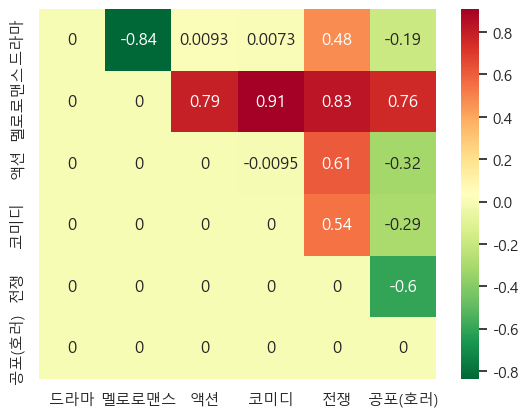

In [22]:
# 재현성을 위해 난수 생성기의 시드 고정
np.random.seed(0)

# seaborn에 한글 지원 폰트 설정
sns.set(font='Malgun Gothic')

# 마이너스 부호 올바르게 표시하기 위한 설정
plt.rcParams['axes.unicode_minus'] = False

# heatmap 생성 및 시각화
# matrix: 시각화할 데이터
# xticklabels, yticklabels: x, y축 레이블
# annot=True: 각 셀에 숫자 표기
# cmap='RdYlGn_r': 색상 팔레트 설정
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')

# 생성된 heatmap 출력
ax


"드라마 멜로로맨스 -0.8526599"은 "드라마" 장르와 "멜로로맨스" 장르가 어떤 특정 개념에 대해 반대 방향의 편향성을 갖고 있음을 의미한다. 즉, 드라마 장르와 멜로로맨스 장르는 서로 많이 다른 특징을 가지고 있다.

"멜로로맨스 액션 0.76285315"은 "멜로로맨스" 장르와 "액션" 장르가 어떤 특정 개념에 대해 비슷한 방향의 편향성을 갖고 있음을 의미한다. 즉, 멜로로맨스 장르와 액션 장르는 어떤 특정한 측면에서 비슷한 특징을 공유하고 있다.

"액션 코미디 0.050466057"는 "액션" 장르와 "코미디" 장르가 어떤 특정 개념에 대해 거의 비슷한 수준의 편향성을 갖고 있음을 의미한다. 즉, 액션 장르와 코미디 장르는 해당 개념에 대해 비슷한 정도로 연관성을 가지고 있다.